<a href="https://colab.research.google.com/github/Mano1498/Customer_Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import joblib
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Dataset Link(UCI ML Repo) : https://archive.ics.uci.edu/dataset/352/online+RFM1

In [2]:
data = pd.read_excel("/content/drive/MyDrive/DataSets/Online Retail.xlsx")

In [3]:
df = data.copy()

In [4]:
df.shape

(541909, 8)

In [5]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [6]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

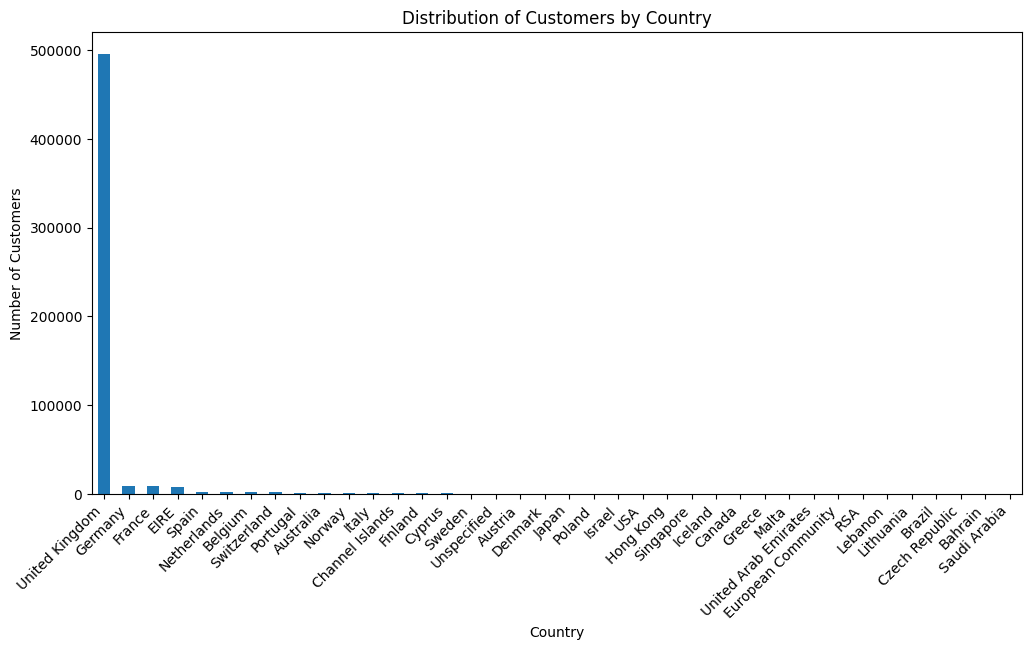

In [8]:
# Distribution of Customer by Country
country_counts = data['Country'].value_counts()
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers by Country')
plt.xticks(rotation=45, ha='right') # ha - horizonatal alingment
plt.show()

In [9]:
df["CustomerID"].nunique()

4372

In [10]:
country_wise_dis = df[["Country","CustomerID"]].drop_duplicates()
result = country_wise_dis.groupby(["Country"])["CustomerID"].aggregate("count").reset_index().sort_values("CustomerID",ascending=False)
result.head()

Country  CustomerID
36  United Kingdom        3950
14         Germany          95
13          France          87
31           Spain          31
3          Belgium          25

In [11]:
df = df[df['Country'] == 'United Kingdom'].reset_index(drop=True) #  keeping only united Kingdom data

In [12]:
df = df.dropna(subset=['CustomerID'])
df = df.reset_index(drop=True)

In [13]:
# Filtering negative values
df = df[(df['Quantity']>0)]
df = df[(df['UnitPrice']>0)]

In [14]:
df["TotalAmount"] = df['Quantity']*df['UnitPrice'] # Creating Total amount column

In [15]:
df.shape

(354321, 9)

In [16]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34

## Calculating R,F,M values

In [17]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [18]:
rfm_a = df.groupby("CustomerID")["TotalAmount"].sum()
rfm_a = rfm_a.reset_index()
rfm_a.columns = ["CustomerID","Monetary"]

In [19]:
rfm_a['Monetary'] = rfm_a['Monetary'].round().astype(int)

In [20]:
rfm_a.head()

CustomerID  Monetary
0       12346     77184
1       12747      4196
2       12748     33720
3       12749      4091
4       12820       942

In [21]:
rfm_f = df.groupby("CustomerID")["InvoiceNo"].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ["CustomerID","Frequency"]

In [22]:
rfm_f.head()

CustomerID  Frequency
0       12346          1
1       12747        103
2       12748       4595
3       12749        199
4       12820         59

In [23]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
current_date = df['InvoiceDate'].max()

In [24]:
current_date

Timestamp('2011-12-09 12:49:00')

In [25]:
rfm_r = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
rfm_r.columns = ['CustomerID', 'LastPurchaseDate']

In [26]:
rfm_r['Recency'] = (current_date - rfm_r['LastPurchaseDate']).dt.days # extract the number of days from a pandas Timestamp

In [27]:
rfm_r.head()

CustomerID    LastPurchaseDate  Recency
0       12346 2011-01-18 10:01:00      325
1       12747 2011-12-07 14:34:00        1
2       12748 2011-12-09 12:20:00        0
3       12749 2011-12-06 09:56:00        3
4       12820 2011-12-06 15:12:00        2

In [28]:
rfm_r = rfm_r.drop('LastPurchaseDate', axis=1)

In [29]:
rfm_r.head()

CustomerID  Recency
0       12346      325
1       12747        1
2       12748        0
3       12749        3
4       12820        2

In [30]:
RFM = pd.merge(rfm_r ,rfm_f , on="CustomerID",how="inner") # Joins rows with matching values
RFM.head()

CustomerID  Recency  Frequency
0       12346      325          1
1       12747        1        103
2       12748        0       4595
3       12749        3        199
4       12820        2         59

In [31]:
RFM = pd.merge(RFM ,rfm_a , on="CustomerID",how="inner")
RFM.head()

CustomerID  Recency  Frequency  Monetary
0       12346      325          1     77184
1       12747        1        103      4196
2       12748        0       4595     33720
3       12749        3        199      4091
4       12820        2         59       942

In [32]:
RFM.shape

(3920, 4)

## Outliers Detection and Removal

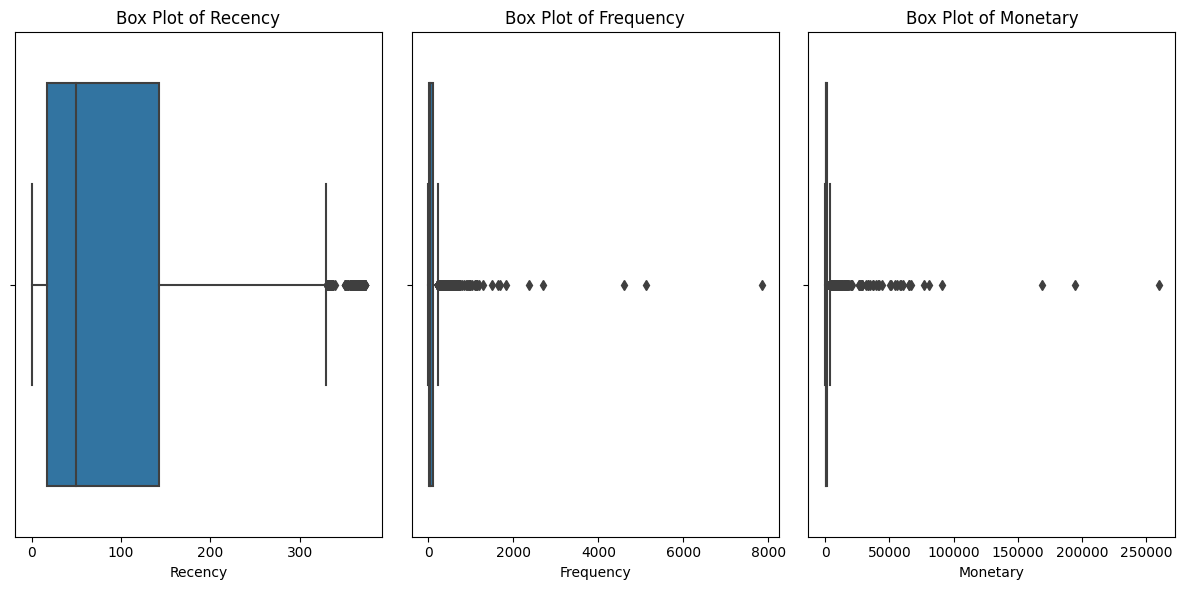

In [33]:
plt.figure(figsize=(12, 6)) # 12 inches in width and 6 inches in height

# Box plot for Recency
plt.subplot(1, 3, 1)                                      # Creating subplots with 1 row and 3 columns
sns.boxplot(x='Recency', data=RFM, orient='v')            # Box plot in Vertical Orientation
plt.title('Box Plot of Recency')

# Box plot for Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Frequency', data=RFM, orient='v')
plt.title('Box Plot of Frequency')

# Box plot for Monetary
plt.subplot(1, 3, 3)
sns.boxplot(x='Monetary', data=RFM, orient='v')
plt.title('Box Plot of Monetary')

# Adjust the layout
plt.tight_layout()

# Show the box plots
plt.show()

In [34]:
# Function to remove Outliers Using IQR Method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
columns_to_remove_outliers = ['Recency', 'Frequency', 'Monetary']
RFM1= remove_outliers(RFM, columns_to_remove_outliers)

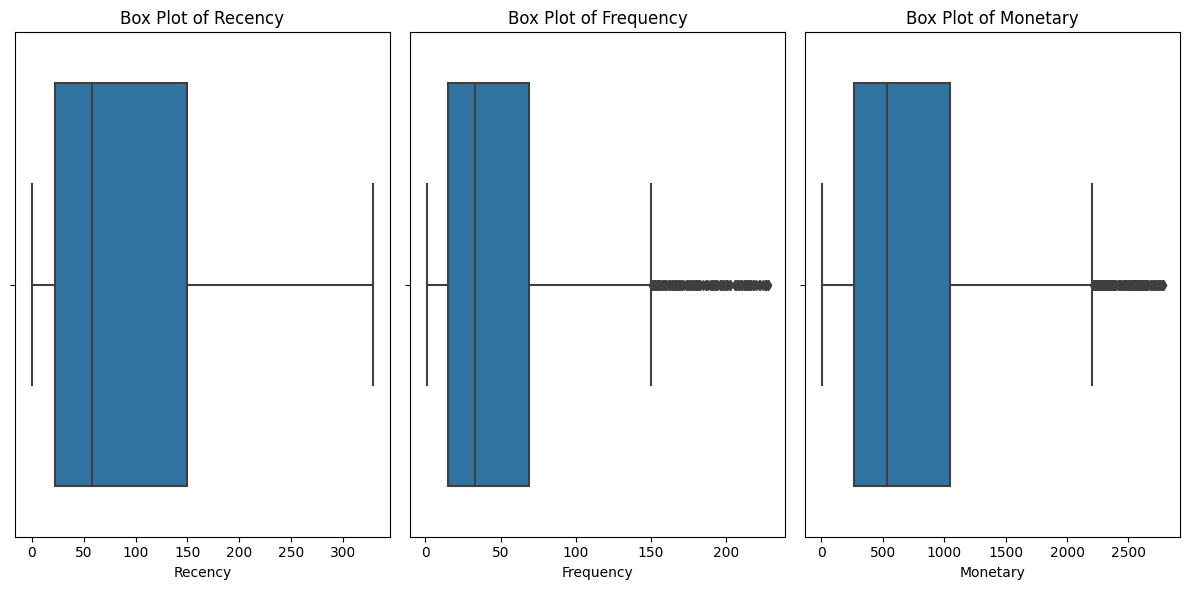

In [35]:
plt.figure(figsize=(12, 6))

# Box plot for Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='Recency', data=RFM1, orient='v')
plt.title('Box Plot of Recency')

# Box plot for Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Frequency', data=RFM1, orient='v')
plt.title('Box Plot of Frequency')

# Box plot for Monetary
plt.subplot(1, 3, 3)
sns.boxplot(x='Monetary', data=RFM1, orient='v')
plt.title('Box Plot of Monetary')

# Adjust the layout
plt.tight_layout()

# Show the box plots
plt.show()

In [36]:
RFM1.Recency.describe()

count    3179.000000
mean       92.512425
std        89.960711
min         0.000000
25%        22.000000
50%        58.000000
75%       149.500000
max       329.000000
Name: Recency, dtype: float64

In [37]:
RFM1.Frequency.describe()

count    3179.000000
mean       48.878893
std        45.965012
min         1.000000
25%        15.000000
50%        33.000000
75%        69.000000
max       228.000000
Name: Frequency, dtype: float64

In [38]:
RFM1.Monetary.describe()

count    3179.000000
mean      742.894306
std       634.685894
min         4.000000
25%       267.000000
50%       530.000000
75%      1043.000000
max      2781.000000
Name: Monetary, dtype: float64

## Calculating RFM Scores

In [39]:
#Split into four segments using quantiles
quantiles = RFM1.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [40]:
quantiles

{'CustomerID': {0.25: 14200.0, 0.5: 15571.0, 0.75: 16922.5},
 'Recency': {0.25: 22.0, 0.5: 58.0, 0.75: 149.5},
 'Frequency': {0.25: 15.0, 0.5: 33.0, 0.75: 69.0},
 'Monetary': {0.25: 267.0, 0.5: 530.0, 0.75: 1043.0}}

In [41]:
quantiles.keys()

dict_keys(['CustomerID', 'Recency', 'Frequency', 'Monetary'])

In [42]:
#Functions to create R, F and M segments
def RScoring(x,p,d):                   # d = quantiles dict , p = quantiles keys , x = Recency value
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FnMScoring(x,p,d):                 # d = quantiles dict , p = quantiles keys , x = Frequency and Monetary values
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [43]:
RFM1['R-Score'] = RFM1['Recency'].apply(RScoring, args=('Recency',quantiles))
RFM1['F-Score'] = RFM1['Frequency'].apply(FnMScoring, args=('Frequency',quantiles))
RFM1['M-Score'] = RFM1['Monetary'].apply(FnMScoring, args=('Monetary',quantiles))
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score
4       12820        2         59       942        1        2        2
5       12821      213          6        93        4        4        4
6       12822       70         46       949        3        2        2
7       12823       74          5      1760        3        4        1
8       12824       59         25       397        3        3        3

In [44]:
RFM1['RFMScore'] = RFM1['R-Score'] + RFM1['F-Score'] + RFM1['M-Score']

In [45]:
RFM1.shape

(3179, 8)

In [46]:
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score  \
4       12820        2         59       942        1        2        2   
5       12821      213          6        93        4        4        4   
6       12822       70         46       949        3        2        2   
7       12823       74          5      1760        3        4        1   
8       12824       59         25       397        3        3        3   

   RFMScore  
4         5  
5        12  
6         7  
7         8  
8         9

## Assigning Loyalty Levels Based on RFM Scores

In [47]:
# function to assign loyalty levels based on 'RFM1Score'
def LoyaltyLevel(row):
    if row['RFMScore'] >= 10:
        return 'Bronze'
    elif row['RFMScore'] >= 8:
        return 'Silver'
    elif row['RFMScore'] >= 6:
        return 'Gold'
    else:
        return 'Platinum'
# Apply the LoyaltyLevel function to DataFrame
RFM1['LoyaltyLevel'] = RFM1.apply(LoyaltyLevel, axis=1)

In [48]:
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score  \
4       12820        2         59       942        1        2        2   
5       12821      213          6        93        4        4        4   
6       12822       70         46       949        3        2        2   
7       12823       74          5      1760        3        4        1   
8       12824       59         25       397        3        3        3   

   RFMScore LoyaltyLevel  
4         5     Platinum  
5        12       Bronze  
6         7         Gold  
7         8       Silver  
8         9       Silver

## Data Visualization

In [49]:
loyalty_colors = {
    'Platinum': '#0065A4',  # Dark Blue
    'Gold': '#FFD700',      # Gold
    'Silver': '#808080',    # Gray
    'Bronze': '#D2691E'     # Chocolate
}

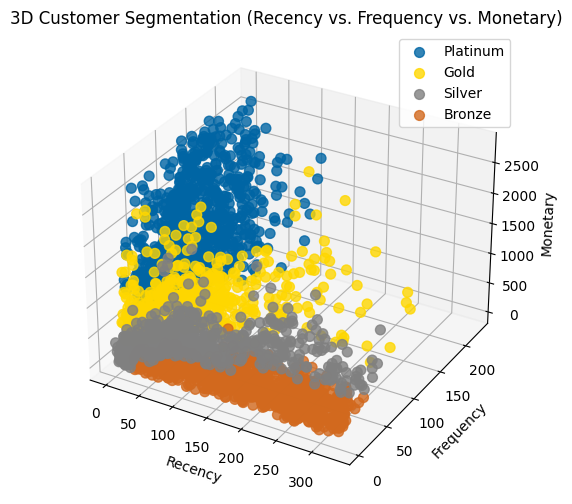

In [50]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')                                                                                   #111 - fig 1row,1column at position 1
for loyalty_level, color in loyalty_colors.items():
    subset = RFM1[RFM1['LoyaltyLevel'] == loyalty_level]                                                                 # label - assigns a label to the data points (for legend)
    ax.scatter(subset['Recency'], subset['Frequency'], subset['Monetary'], c=color, label=loyalty_level, s=50, alpha=0.8)    # s - Size of data points , alpha - transparency
ax.set_xlabel('Recency')                                                                                                     # c - set color of data point
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Customer Segmentation (Recency vs. Frequency vs. Monetary)')
ax.legend()
plt.show()

In [51]:
pip install plotly # For Interactive Plot

about plotly : https://plotly.com/

In [52]:
import plotly.express as px
fig = px.scatter_3d(RFM1, x='Recency', y='Frequency', z='Monetary', color='LoyaltyLevel', hover_name='CustomerID')
fig.update_layout(
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary',
    ),
    title='3D Customer Segmentation (Recency vs. Frequency vs. Monetary)'
)
fig.show()

## Displaying Image of Interactive Plot for Github

In [53]:
#from google.colab import files
#from IPython.display import Image
#Uploaded = files.upload()
#Image("Interactive Plot.png")

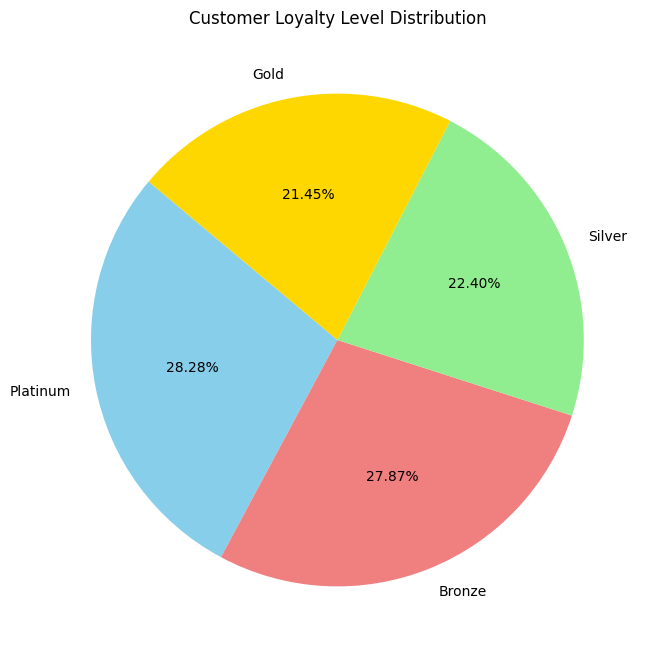

In [54]:
# Count the number of customers in each loyalty level
loyalty_counts = RFM1['LoyaltyLevel'].value_counts()
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(loyalty_counts, labels=loyalty_counts.index, autopct='%1.2f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Customer Loyalty Level Distribution')
plt.show()

## RFM Segmented Customer Information

In [55]:
features = ["Recency","Frequency","Monetary"]
data = RFM1[features].copy()
data = data.reset_index(drop=True)

In [56]:
data.head()

Recency  Frequency  Monetary
0        2         59       942
1      213          6        93
2       70         46       949
3       74          5      1760
4       59         25       397

<Axes: >

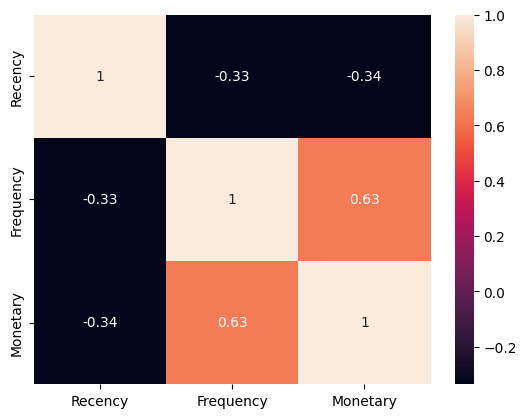

In [57]:
sns.heatmap(data.corr(), annot=True)

<Axes: xlabel='Recency', ylabel='Count'>

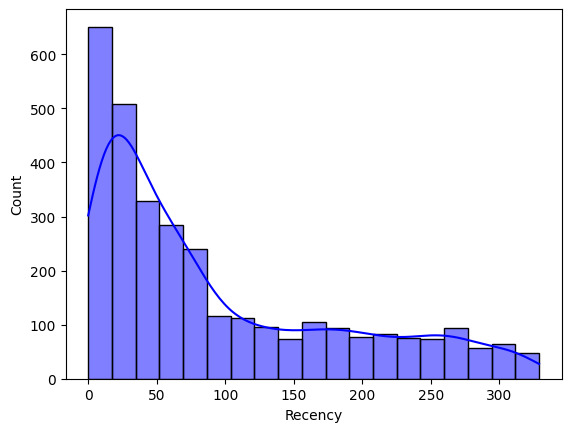

In [58]:
sns.histplot(data.Recency,kde=True,color="blue")

<Axes: xlabel='Frequency', ylabel='Count'>

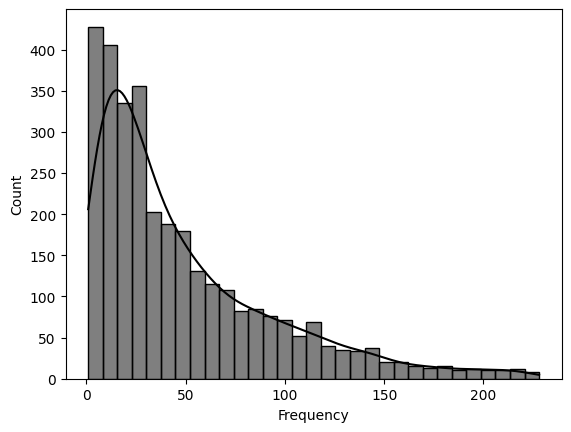

In [59]:
sns.histplot(data.Frequency,kde=True,color="black")

<Axes: xlabel='Monetary', ylabel='Count'>

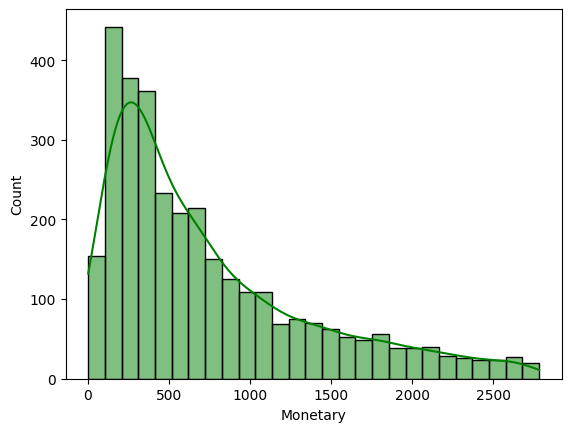

In [60]:
sns.histplot(data.Monetary,kde=True,color="green")

In [61]:
data[["Recency", "Frequency", "Monetary"]].min()

Recency      0
Frequency    1
Monetary     4
dtype: int64

In [62]:
data["Recency"].replace(0,1,inplace=True)

Lambda value : 0.23921326158697623


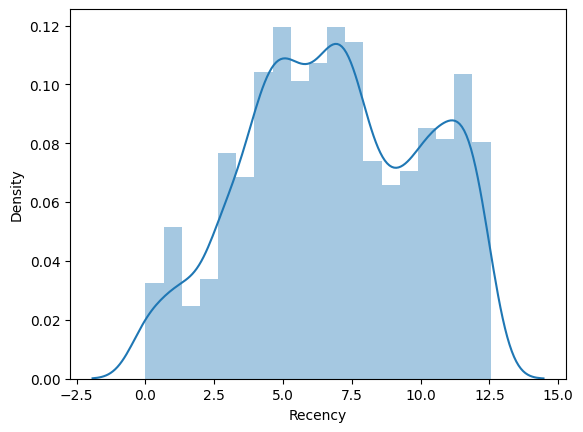

In [63]:
data["Recency"], lam_r = stats.boxcox(data["Recency"])
sns.distplot(data.Recency)
print("Lambda value :",lam_r)

Lambda value : 0.21730579181694484


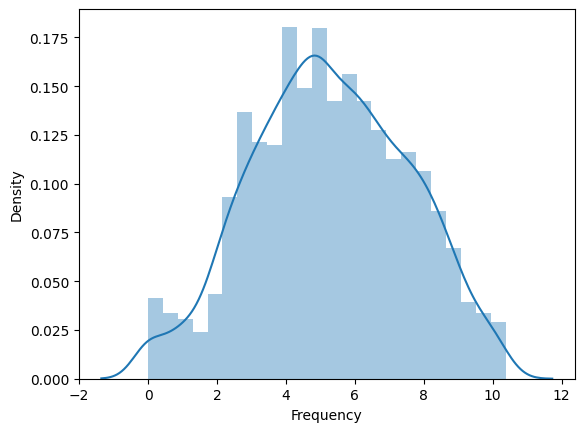

In [64]:


data["Frequency"], lam_f = stats.boxcox(data["Frequency"])
sns.distplot(data.Frequency)
print("Lambda value :",lam_f)

Lambda value : 0.1616362633541601


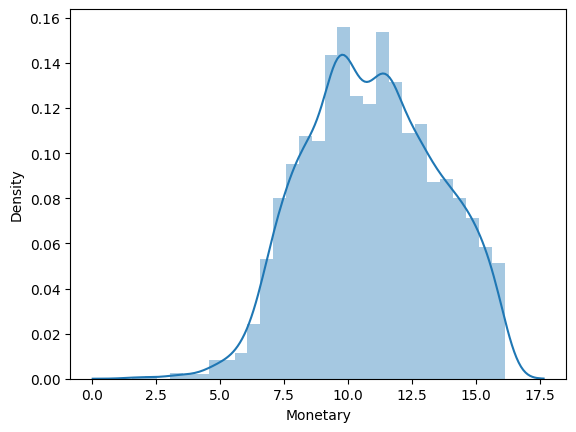

In [65]:
data["Monetary"], lam_m = stats.boxcox(data["Monetary"])
sns.distplot(data.Monetary)
print("Lambda value :",lam_m)

In [66]:
scl = StandardScaler()
c = ["Recency","Frequency","Monetary"]
data[c] = scl.fit_transform(data[c])

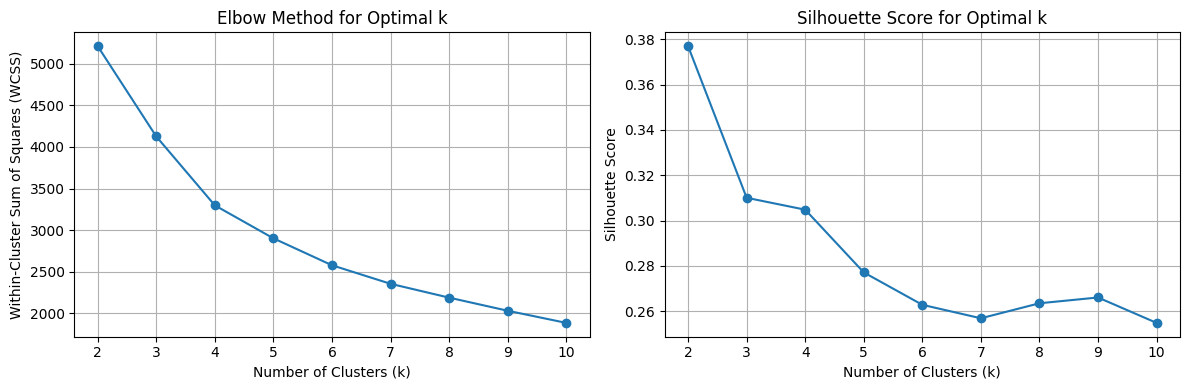

In [67]:
k_values = range(2, 11)

wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

fig, (el, sl) = plt.subplots(1, 2, figsize=(12, 4))    # 1 row and 2 column
# Elbow method plot
el.plot(k_values, wcss, marker='o')
el.set_xlabel('Number of Clusters (k)')
el.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
el.set_title('Elbow Method for Optimal k')
el.grid(True)
# Silhouette score plot
sl.plot(k_values, silhouette_scores, marker='o')
sl.set_xlabel('Number of Clusters (k)')
sl.set_ylabel('Silhouette Score')
sl.set_title('Silhouette Score for Optimal k')
sl.grid(True)

plt.tight_layout()
plt.show()

In [68]:
wcss

[5211.017104302047,
 4125.666717579258,
 3297.4976742974795,
 2901.2567116980067,
 2577.5613300885507,
 2354.6428533011813,
 2188.21446386182,
 2030.84303346358,
 1884.6399013854352]

In [69]:
silhouette_scores

[0.3769690007541157,
 0.31002829821683664,
 0.30477269965083115,
 0.2770813032903883,
 0.262776143202614,
 0.2568298856194972,
 0.2634555279263991,
 0.2660117687633464,
 0.25479531798541505]

# Reference for Silhouette Plot

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

For n_clusters = 2, the average silhouette_score is : 0.38
For n_clusters = 3, the average silhouette_score is : 0.31
For n_clusters = 4, the average silhouette_score is : 0.30
For n_clusters = 5, the average silhouette_score is : 0.28
For n_clusters = 6, the average silhouette_score is : 0.26
For n_clusters = 7, the average silhouette_score is : 0.26
For n_clusters = 8, the average silhouette_score is : 0.26
For n_clusters = 9, the average silhouette_score is : 0.26
For n_clusters = 10, the average silhouette_score is : 0.26


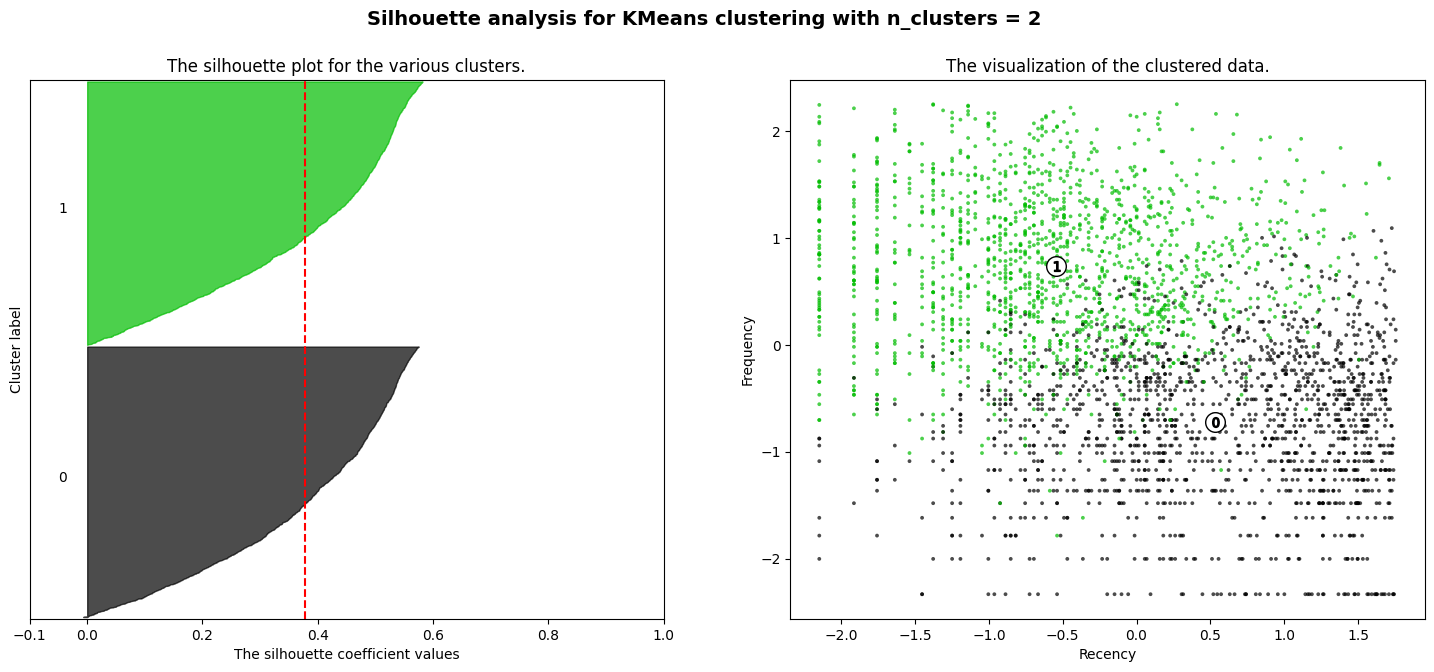

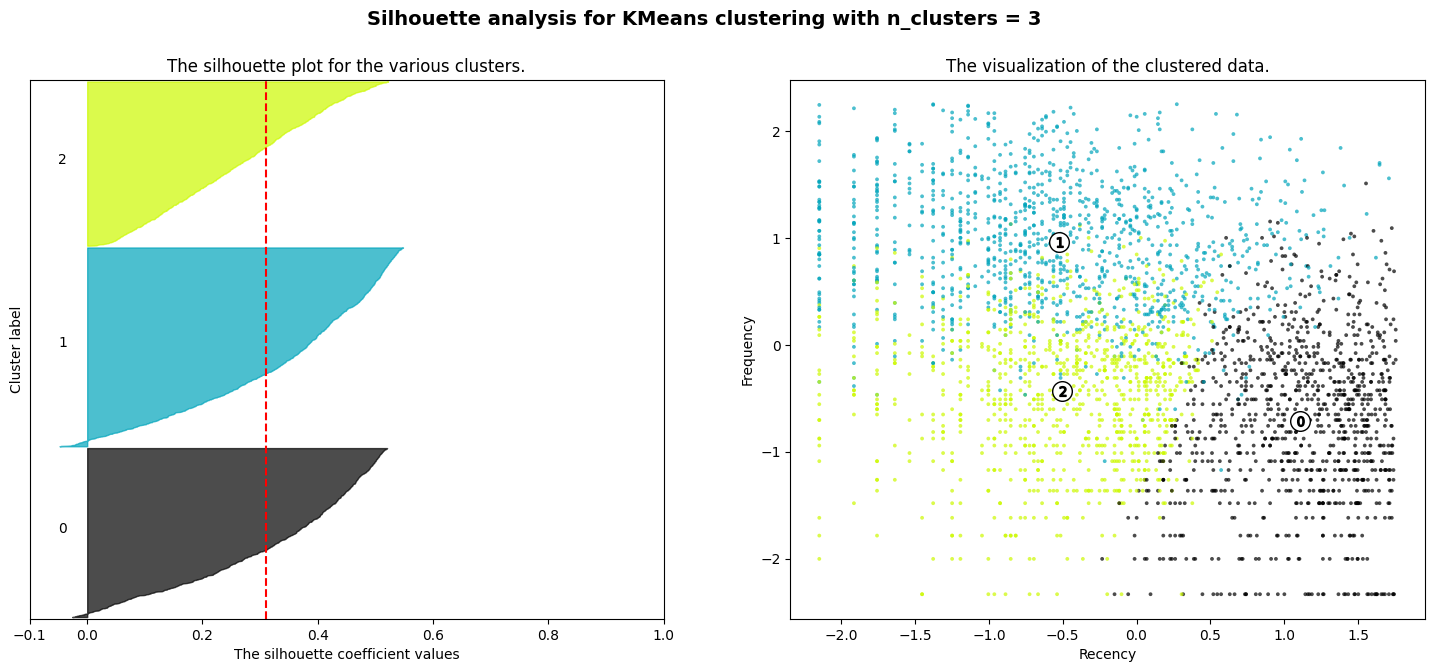

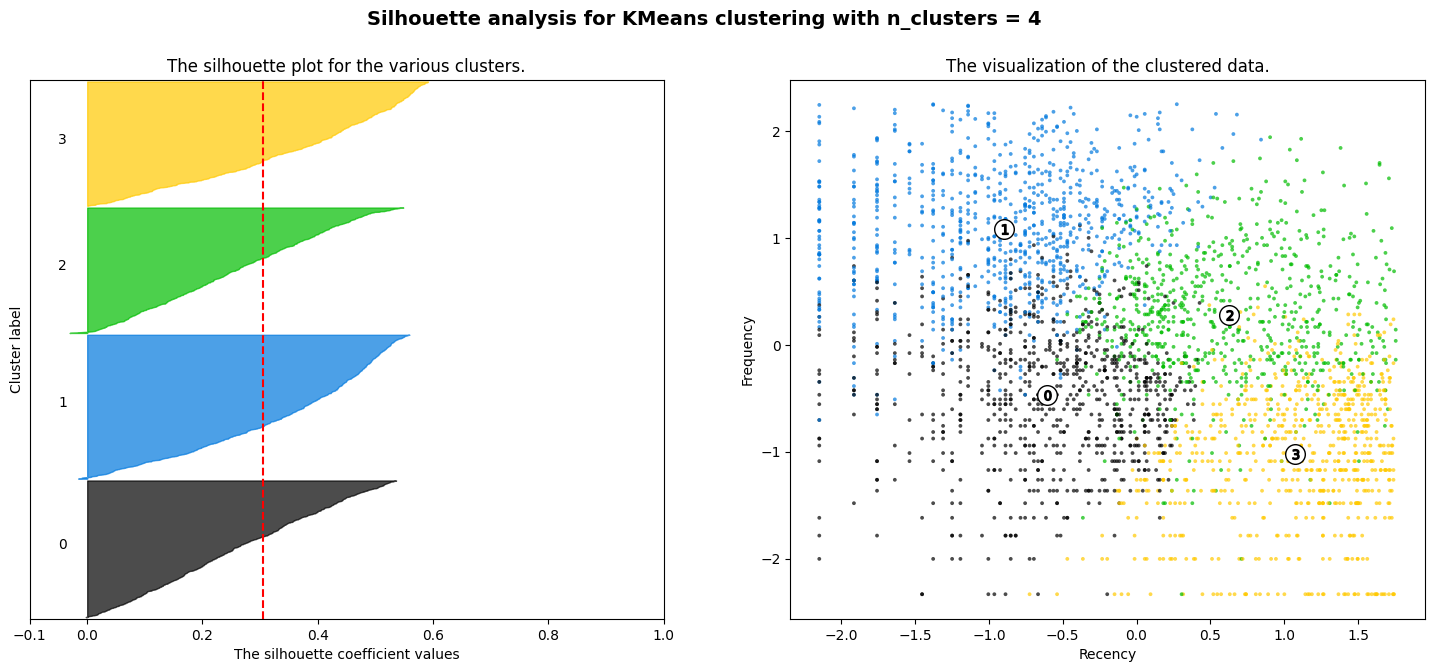

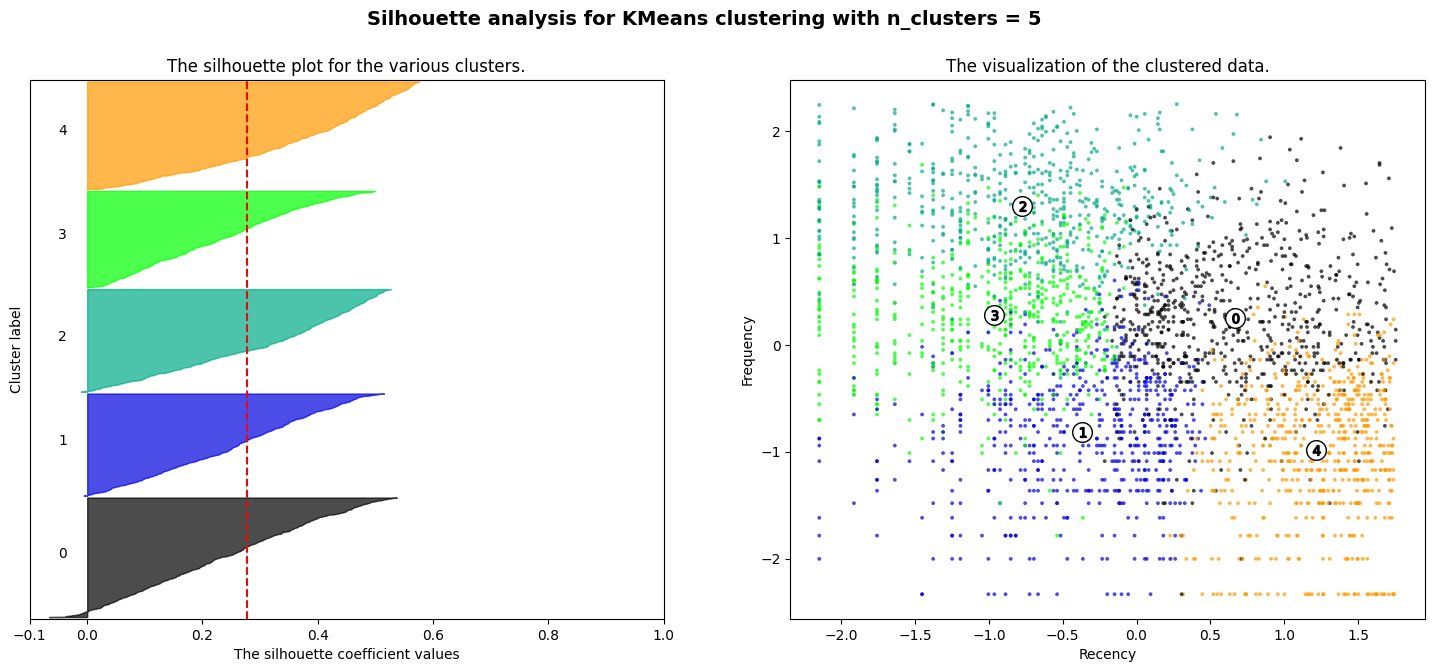

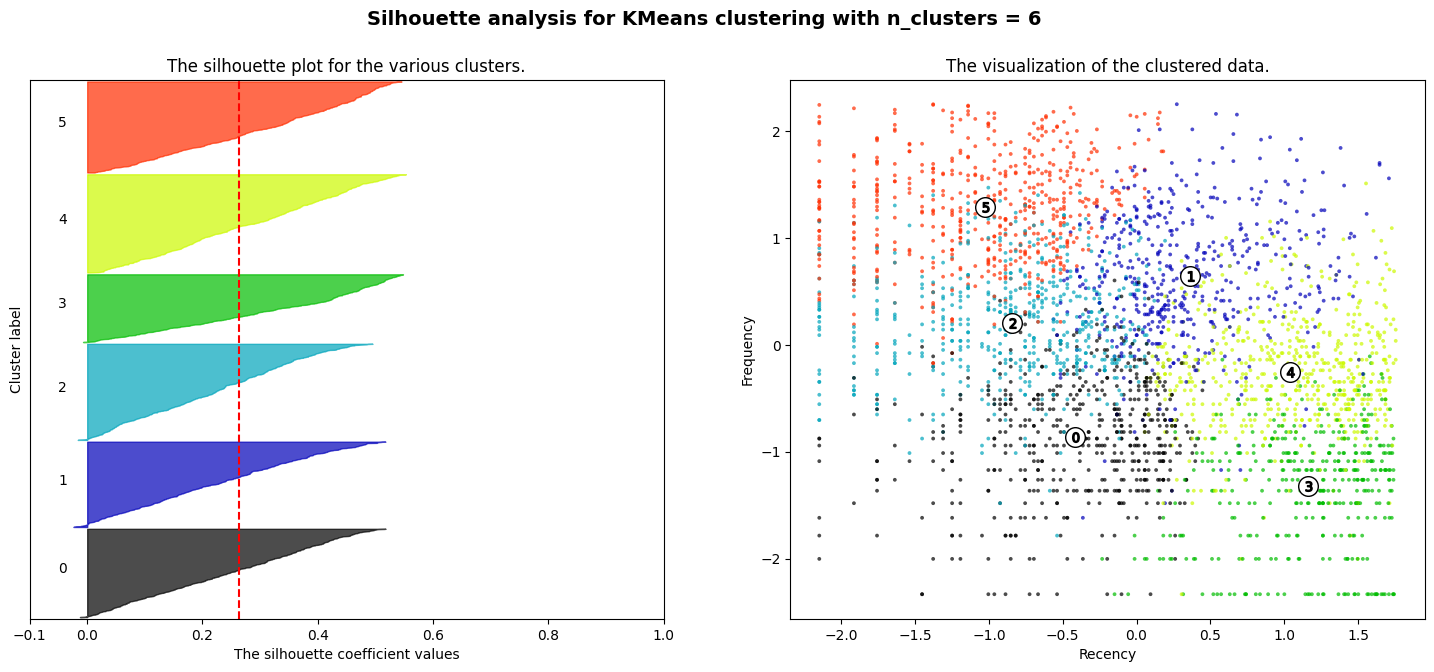

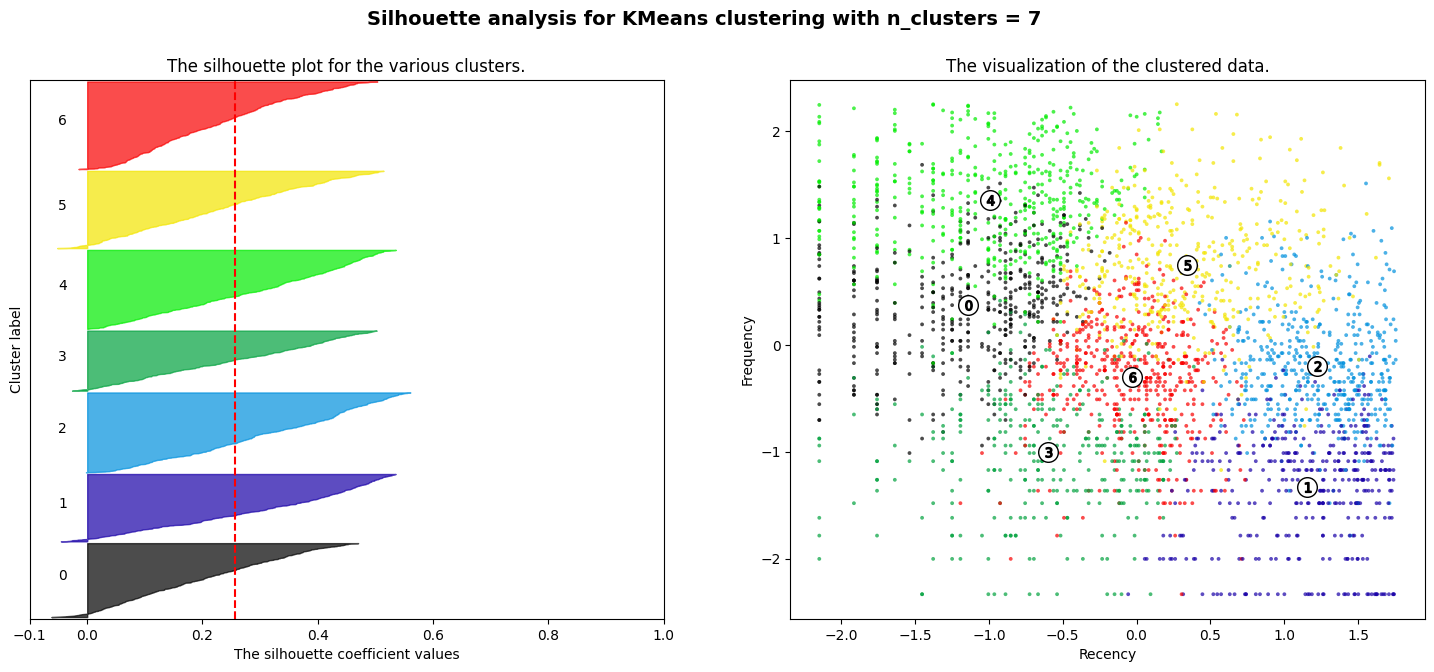

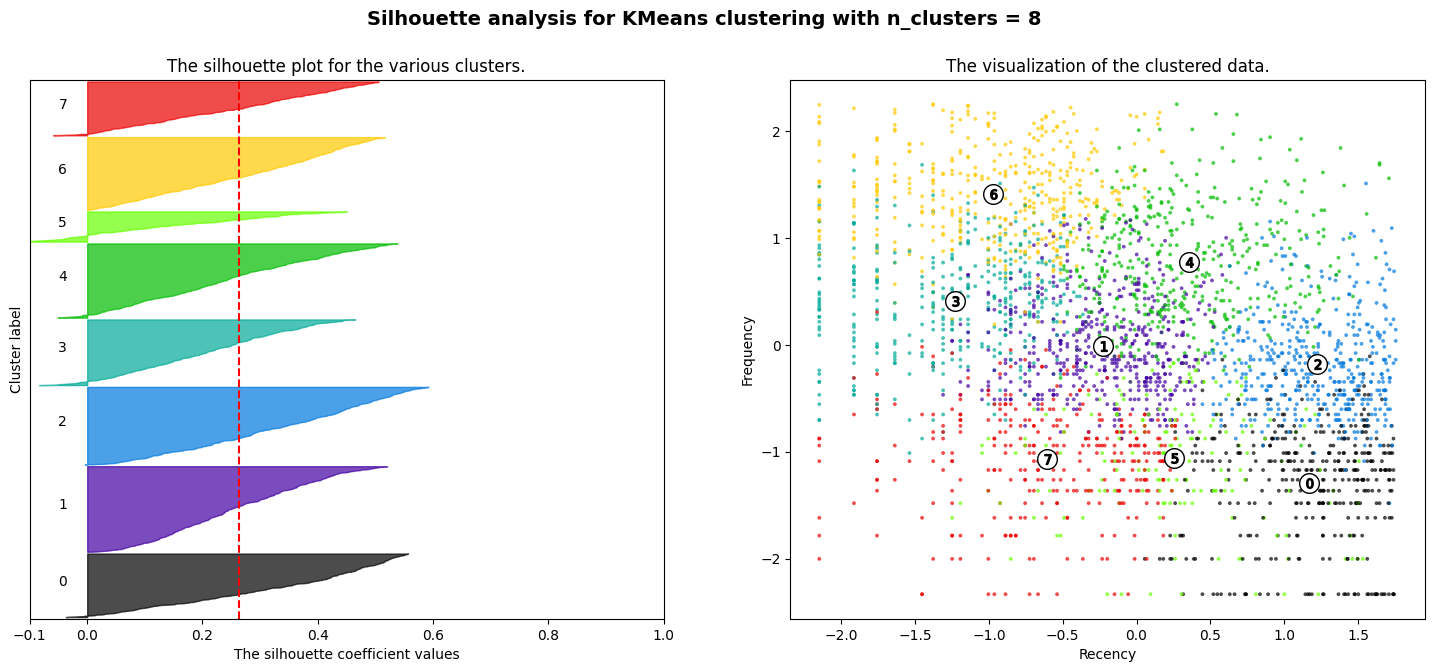

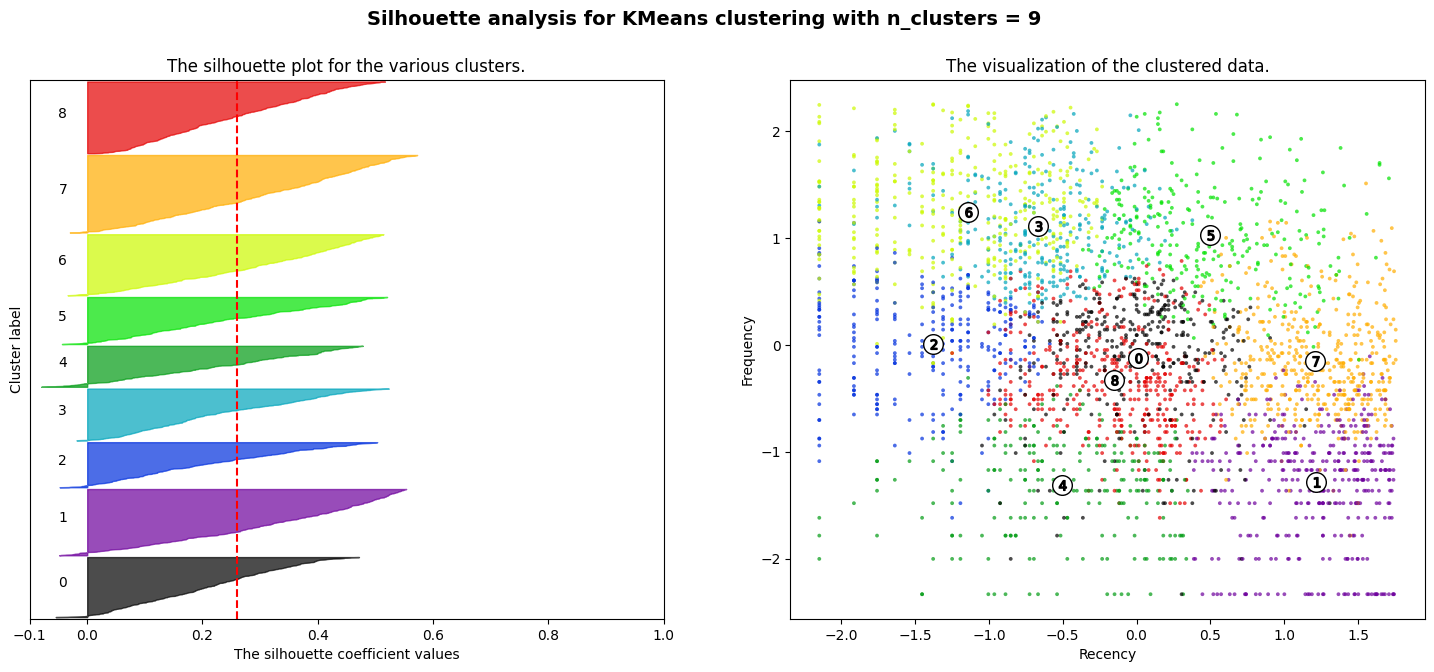

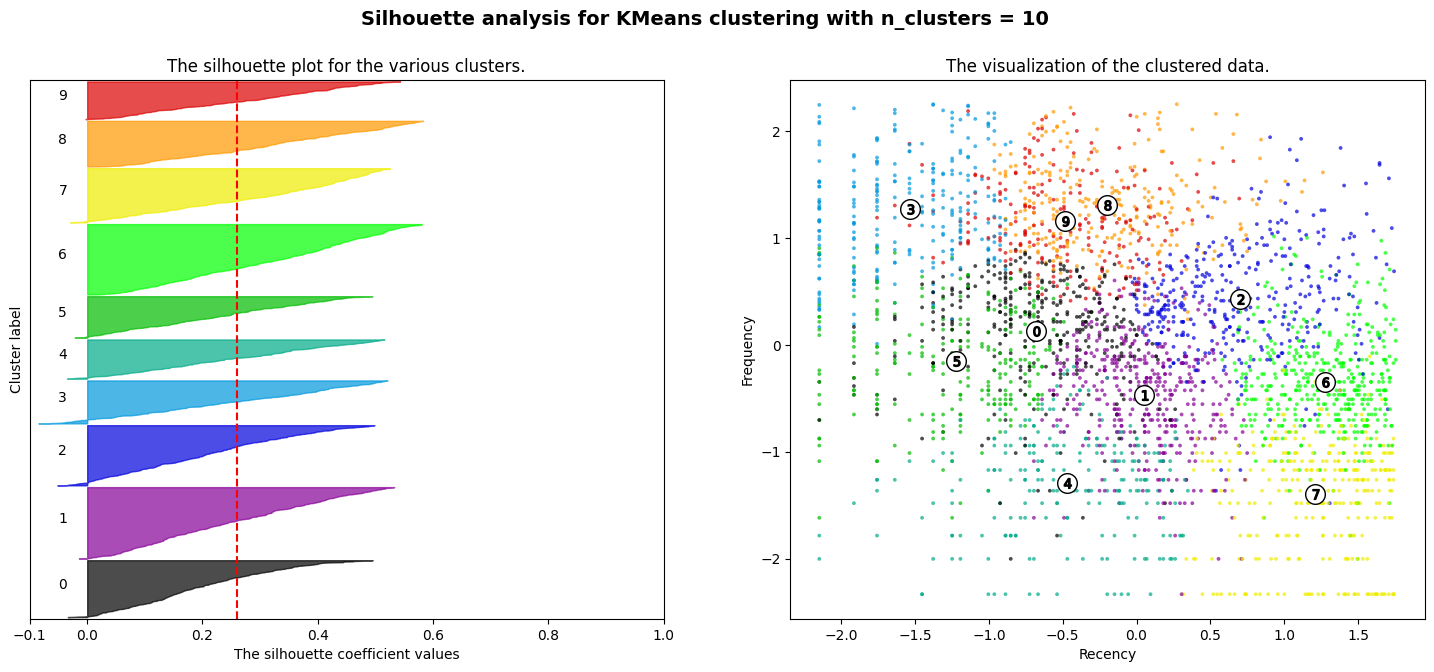

In [70]:

# Extract the features from your DataFrame
X = data[["Recency", "Frequency", "Monetary"]].values

# Define the range of k values you want to explore
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the KMeans clusterer with n_clusters value and a random generator seed for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.2f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Recency")
    ax2.set_ylabel("Frequency")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [71]:
# Init. random centroids
def random_centroids(data,k):
  centroids = []
  for i in range(k):
    centroid = data.apply(lambda x: float(x.sample()))
    centroids.append(centroid)
  return pd.concat(centroids,axis=1)

In [72]:
# Manhattan distances
def get_labels_Manhattan(data, centroids):
    distances = centroids.apply(lambda x: np.abs(data - x).sum(axis=1))
    labels = distances.idxmin(axis=1)
    return labels

In [73]:
# Euclidean Distance
def get_labels_euclidean(data,centroids):
  distances = centroids.apply(lambda x:np.sqrt(((data-x)**2).sum(axis=1)))
  return distances.idxmin(axis=1)

In [74]:
# arithmetic arithmeti mean
def new_centroids_arithmetic(data, labels, k):
    new_centroids = data.groupby(labels).mean().T
    return new_centroids

In [75]:
# geometric mean
def new_centroids_geometric(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [199]:
max_iterations = 100
centroid_count = 2
centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

results = []

while iteration <= max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids

    # Manhattan with arithmetic mean
    labels_Manhattan = get_labels_Manhattan(data, centroids)
    centroids_arithmetic = new_centroids_arithmetic(data, labels_Manhattan, centroid_count)
    silhouette_manhattan_arithmetic = silhouette_score(data, labels_Manhattan)
    # Euclidean with arithmetic mean
    labels_euclidean = get_labels_euclidean(data, centroids)
    centroids_arithmetic = new_centroids_arithmetic(data, labels_euclidean, centroid_count)
    silhouette_euclidean_arithmetic = silhouette_score(data, labels_euclidean)
    # Manhattan with geometric mean
    labels_Manhattan = get_labels_Manhattan(data, centroids)
    centroids_geometric = new_centroids_geometric(data, labels_Manhattan, centroid_count)
    silhouette_manhattan_geometric = silhouette_score(data, labels_Manhattan)
    # Euclidean with geometric mean
    labels_euclidean = get_labels_euclidean(data, centroids)
    centroids_geometric = new_centroids_geometric(data, labels_euclidean, centroid_count)
    silhouette_euclidean_geometric = silhouette_score(data, labels_euclidean)

    results.append({
        'Distance Metric': 'Manhattan',
        'Mean Type': 'Arithmetic',
        'Silhouette Score': silhouette_manhattan_arithmetic
    })
    results.append({
        'Distance Metric': 'Manhattan',
        'Mean Type': 'Geometric',
        'Silhouette Score': silhouette_manhattan_geometric
    })
    results.append({
        'Distance Metric': 'Euclidean',
        'Mean Type': 'Arithmetic',
        'Silhouette Score': silhouette_euclidean_arithmetic
    })
    results.append({
        'Distance Metric': 'Euclidean',
        'Mean Type': 'Geometric',
        'Silhouette Score': silhouette_euclidean_geometric
    })

    iteration += 1

result_df = pd.DataFrame(results)
result_df

Distance Metric   Mean Type  Silhouette Score
0       Manhattan  Arithmetic          0.351549
1       Manhattan   Geometric          0.351549
2       Euclidean  Arithmetic          0.367412
3       Euclidean   Geometric          0.367412

In [77]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

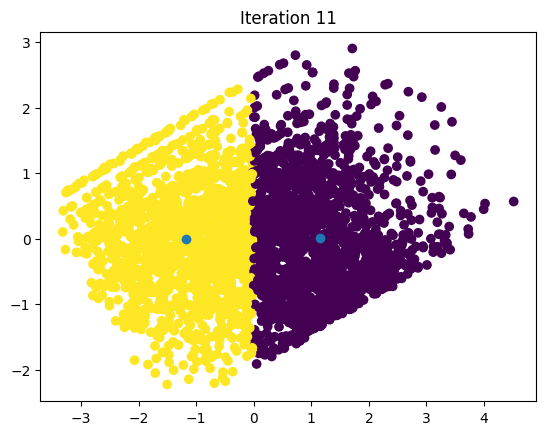

In [78]:
max_iterations = 100
centroid_count = 2

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids


    labels = get_labels_euclidean(data, centroids)    # eculidean or manhatten  mean
    centroids = new_centroids_arithmetic(data, labels, centroid_count)     # geometric or arithmetic mean
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1


In [79]:
silhouette_score(data, labels) * 100

37.69690007541157

In [136]:
kmeans = KMeans(n_clusters=2,max_iter= 100,init='k-means++')
kmeans.fit(data)

KMeans(max_iter=100, n_clusters=2)

In [137]:
def plot_clusters_E(data, labels, centroids):
    pca1 = PCA(n_components=2)
    data_2d1 = pca1.fit_transform(data)
    centroids_2d1 = pca1.transform(centroids)
    clear_output(wait=True)
    plt.scatter(x=data_2d1[:,0], y=data_2d1[:,1], c=labels)
    plt.scatter(x=centroids_2d1[:,0], y=centroids_2d1[:,1])
    plt.show()

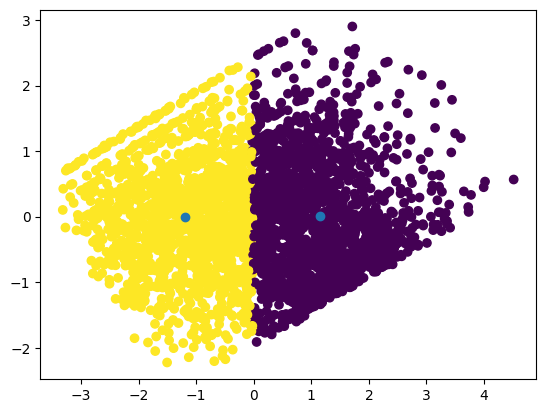

In [138]:
plot_clusters_E(data,kmeans.labels_,kmeans.cluster_centers_)

In [139]:
silhouette_score(data, kmeans.labels_) * 100

37.6951141092008

In [140]:
dbscan = DBSCAN(eps=0.5, min_samples=5) # eps defines the maximum distance between two data points
label_db = dbscan.fit_predict(data)     # min_sample defines the minimum number of data points required to form a dense region (cluster)
silhouette_score(data, label_db)

0.32293581604901195

In [141]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='average')  # linkage : refers to the method used to compute the distance between clusters during the agglomeration (bottom-up) process
label_hir = agglomerative.fit_predict(data)
silhouette_score(data, label_hir)

0.32112361914532583

In [142]:
# For assigning labels
prd = kmeans.predict(data)

In [143]:
RFM1["Cluster_ID"] = prd

In [144]:
RFM1.head()

CustomerID  Recency  Frequency  Monetary  R-Score  F-Score  M-Score  \
4       12820        2         59       942        1        2        2   
5       12821      213          6        93        4        4        4   
6       12822       70         46       949        3        2        2   
7       12823       74          5      1760        3        4        1   
8       12824       59         25       397        3        3        3   

   RFMScore LoyaltyLevel  Cluster_ID  
4         5     Platinum           1  
5        12       Bronze           0  
6         7         Gold           1  
7         8       Silver           0  
8         9       Silver           0

In [145]:
RFM1.to_csv("clusterdcustomer.csv")  # Final Output

In [146]:
RFM1.groupby("Cluster_ID").mean()

CustomerID     Recency  Frequency     Monetary   R-Score  \
Cluster_ID                                                               
0           15568.098765  138.335802  19.019136   323.902469  3.060494   
1           15550.516357   44.896087  79.906992  1178.280308  1.889031   

             F-Score   M-Score  RFMScore  
Cluster_ID                                
0           3.353086  3.321605  9.735185  
1           1.660038  1.651700  5.200770

In [147]:
RFM1.describe(include="O")

LoyaltyLevel
count          3179
unique            4
top        Platinum
freq            899

<Axes: xlabel='Cluster_ID', ylabel='Recency'>

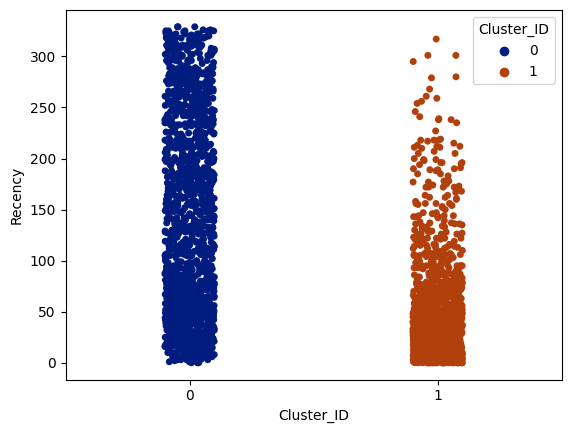

In [148]:
sns.stripplot(x="Cluster_ID",y="Recency",data=RFM1,hue="Cluster_ID", palette="dark")

<Axes: xlabel='Cluster_ID', ylabel='Frequency'>

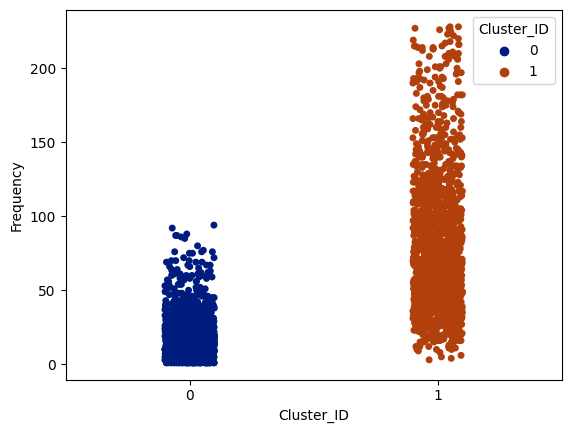

In [149]:
sns.stripplot(x="Cluster_ID",y="Frequency",data=RFM1,hue="Cluster_ID", palette="dark")

<Axes: xlabel='Cluster_ID', ylabel='Monetary'>

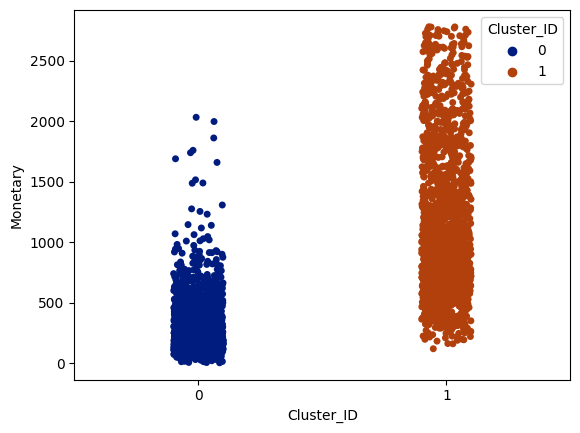

In [150]:
sns.stripplot(x="Cluster_ID",y="Monetary",data=RFM1,hue="Cluster_ID", palette="dark")

In [151]:
RFM1.groupby("Cluster_ID")["LoyaltyLevel"].value_counts()

Cluster_ID  LoyaltyLevel
0           Bronze          886
            Silver          646
            Gold             88
1           Platinum        899
            Gold            594
            Silver           66
Name: LoyaltyLevel, dtype: int64

In [152]:
RFM1[RFM1['LoyaltyLevel'] == "Bronze"].describe().T

count          mean          std      min      25%      50%  \
CustomerID  886.0  15555.493228  1604.203027  12821.0  14144.0  15527.0   
Recency     886.0    178.840858    87.400465     23.0     94.0    185.5   
Frequency   886.0     12.975169     9.318316      1.0      6.0     11.0   
Monetary    886.0    237.092551   146.914166      4.0    134.0    204.0   
R-Score     886.0      3.533860     0.682703      2.0      3.0      4.0   
F-Score     886.0      3.679458     0.513068      2.0      3.0      4.0   
M-Score     886.0      3.635440     0.537043      2.0      3.0      4.0   
RFMScore    886.0     10.848758     0.827312     10.0     10.0     11.0   
Cluster_ID  886.0      0.000000     0.000000      0.0      0.0      0.0   

                 75%      max  
CustomerID  16964.50  18281.0  
Recency       253.00    326.0  
Frequency      17.00     67.0  
Monetary      313.75   1020.0  
R-Score         4.00      4.0  
F-Score         4.00      4.0  
M-Score         4.00      4.0  
RFMScore       12.00     12.0  
Cluster_ID      0.00      0.0

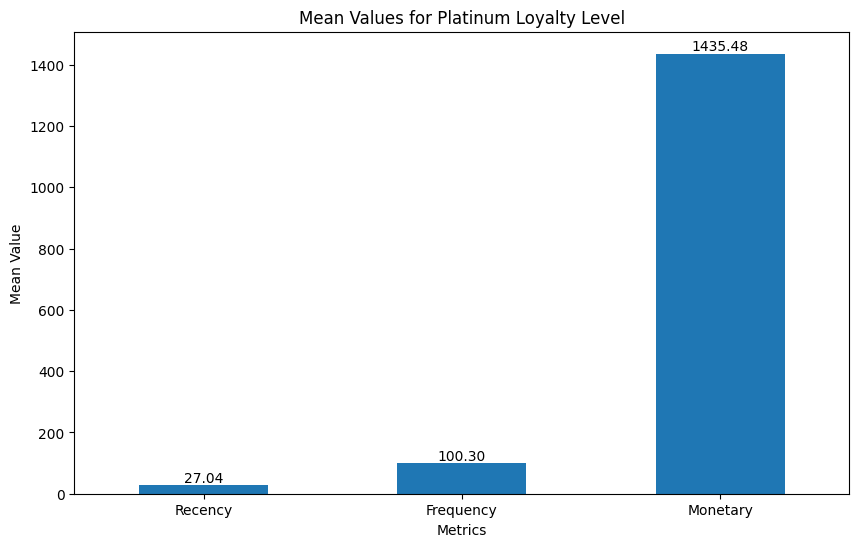

In [153]:

platinum_data = RFM1[RFM1['LoyaltyLevel'] == "Platinum"][['Recency', 'Frequency', 'Monetary']].mean()


plt.figure(figsize=(10, 6))
platinum_data.plot(kind='bar', rot=0)
plt.title('Mean Values for Platinum Loyalty Level')
plt.xlabel('Metrics')
plt.ylabel('Mean Value')

for i, mean_value in enumerate(platinum_data):
    plt.text(i, mean_value + 0.02, f'{mean_value:.2f}', ha='center', va='bottom')

plt.show()

In [154]:
RFM1[RFM1['LoyaltyLevel'] == "Bronze"].describe().T

count          mean          std      min      25%      50%  \
CustomerID  886.0  15555.493228  1604.203027  12821.0  14144.0  15527.0   
Recency     886.0    178.840858    87.400465     23.0     94.0    185.5   
Frequency   886.0     12.975169     9.318316      1.0      6.0     11.0   
Monetary    886.0    237.092551   146.914166      4.0    134.0    204.0   
R-Score     886.0      3.533860     0.682703      2.0      3.0      4.0   
F-Score     886.0      3.679458     0.513068      2.0      3.0      4.0   
M-Score     886.0      3.635440     0.537043      2.0      3.0      4.0   
RFMScore    886.0     10.848758     0.827312     10.0     10.0     11.0   
Cluster_ID  886.0      0.000000     0.000000      0.0      0.0      0.0   

                 75%      max  
CustomerID  16964.50  18281.0  
Recency       253.00    326.0  
Frequency      17.00     67.0  
Monetary      313.75   1020.0  
R-Score         4.00      4.0  
F-Score         4.00      4.0  
M-Score         4.00      4.0  
RFMScore       12.00     12.0  
Cluster_ID      0.00      0.0

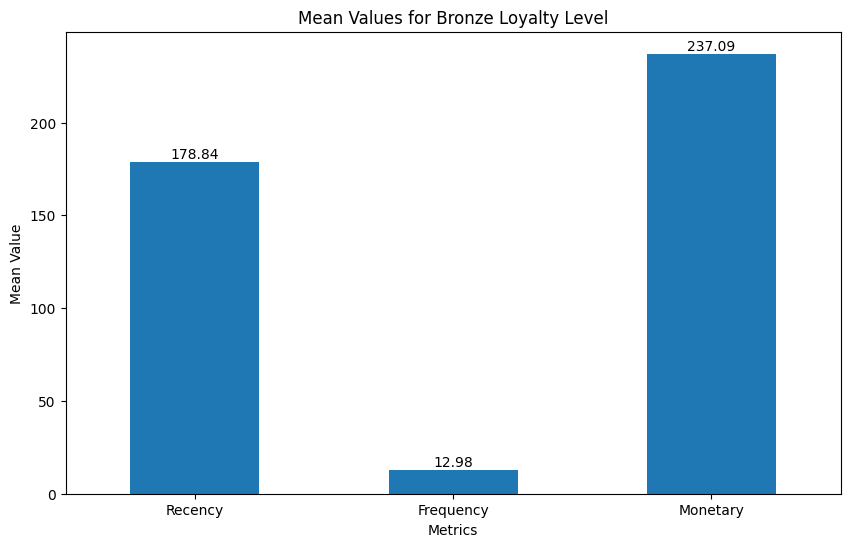

In [155]:

Bronze_data = RFM1[RFM1['LoyaltyLevel'] == "Bronze"][['Recency', 'Frequency', 'Monetary']].mean()

plt.figure(figsize=(10, 6))
ax = Bronze_data.plot(kind='bar', rot=0)
plt.title('Mean Values for Bronze Loyalty Level')
plt.xlabel('Metrics')
plt.ylabel('Mean Value')


for i, mean_value in enumerate(Bronze_data):
    plt.text(i, mean_value + 0.02, f'{mean_value:.2f}', ha='center', va='bottom')

plt.show()

In [156]:
RFM1[kmeans.labels_ == 1][["CustomerID","LoyaltyLevel"] + features]

CustomerID LoyaltyLevel  Recency  Frequency  Monetary
4          12820     Platinum        2         59       942
6          12822         Gold       70         46       949
9          12826     Platinum        2         91      1475
10         12827         Gold        5         25       430
11         12828     Platinum        2         56      1019
...          ...          ...      ...        ...       ...
3900       18259     Platinum       24         42      2339
3901       18260         Gold      172        134      2643
3904       18263     Platinum       25         61      1213
3905       18265         Gold       71         46       802
3919       18287     Platinum       42         70      1837

[1559 rows x 5 columns]

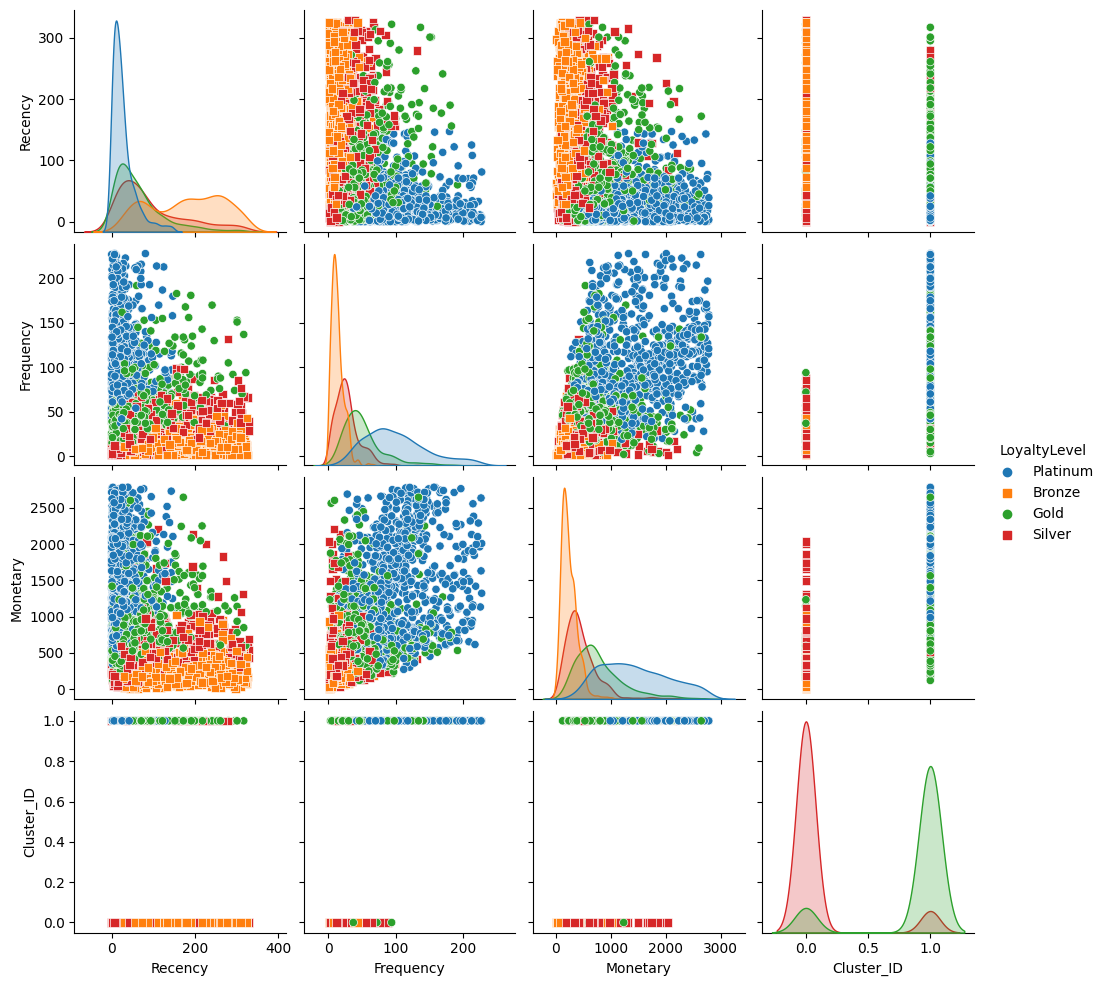

In [157]:
sns.pairplot(RFM1[['Recency','Frequency','Monetary','LoyaltyLevel','Cluster_ID']],hue= 'LoyaltyLevel', markers=["o", "s"])

In [158]:
c0_gold = pd.DataFrame(RFM1[(kmeans.labels_ == 0) & (RFM1['LoyaltyLevel'] == 'Gold')])
c1_gold = pd.DataFrame(RFM1[(kmeans.labels_ == 1) & (RFM1['LoyaltyLevel'] == 'Gold')])
c0_silver = pd.DataFrame(RFM1[(kmeans.labels_ == 0) & (RFM1['LoyaltyLevel'] == 'Silver')])
c1_silver = pd.DataFrame(RFM1[(kmeans.labels_ == 1) & (RFM1['LoyaltyLevel'] == 'Silver')])

In [159]:
combined_df = pd.concat([c0_gold, c1_gold, c0_silver, c1_silver])
#  pivot table to calculate mean values
pivot_table = combined_df.pivot_table(index='Cluster_ID', columns='LoyaltyLevel', values=['Recency', 'Frequency', 'Monetary'], aggfunc='mean')
# Display the pivot table
pivot_table

Frequency               Monetary                Recency  \
LoyaltyLevel       Gold     Silver        Gold      Silver       Gold   
Cluster_ID                                                              
0             32.840909  25.425697  465.750000  423.640867  63.534091   
1             53.043771  43.863636  833.675084  776.333333  64.771044   

                          
LoyaltyLevel      Silver  
Cluster_ID                
0              92.972136  
1             109.212121

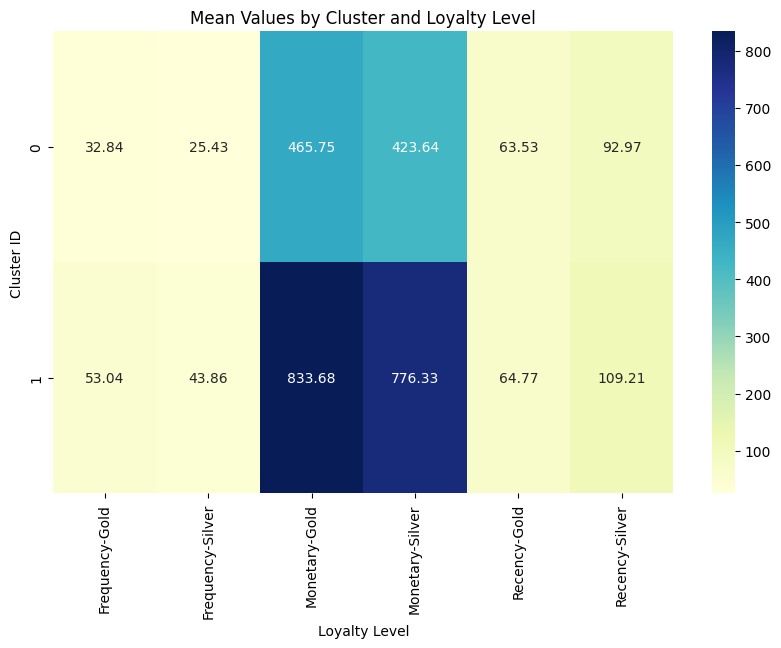

In [160]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Mean Values by Cluster and Loyalty Level')
plt.xlabel('Loyalty Level')
plt.ylabel('Cluster ID')
plt.show()

In [161]:
c0_gold.describe().T

count          mean          std      min       25%      50%  \
CustomerID   88.0  15717.034091  1711.201577  12953.0  14058.00  15661.5   
Recency      88.0     63.534091    75.406477      4.0     16.75     22.0   
Frequency    88.0     32.840909    18.352166      2.0     19.00     34.0   
Monetary     88.0    465.750000   220.311548    132.0    305.75    385.5   
R-Score      88.0      1.852273     1.000457      1.0      1.00      1.0   
F-Score      88.0      2.465909     0.726333      1.0      2.00      2.0   
M-Score      88.0      2.670455     0.738461      1.0      2.00      3.0   
RFMScore     88.0      6.988636     0.106600      6.0      7.00      7.0   
Cluster_ID   88.0      0.000000     0.000000      0.0      0.00      0.0   

                 75%      max  
CustomerID  17411.75  18232.0  
Recency        90.00    322.0  
Frequency      40.00     94.0  
Monetary      610.50   1232.0  
R-Score         3.00      4.0  
F-Score         3.00      4.0  
M-Score         3.00      4.0  
RFMScore        7.00      7.0  
Cluster_ID      0.00      0.0

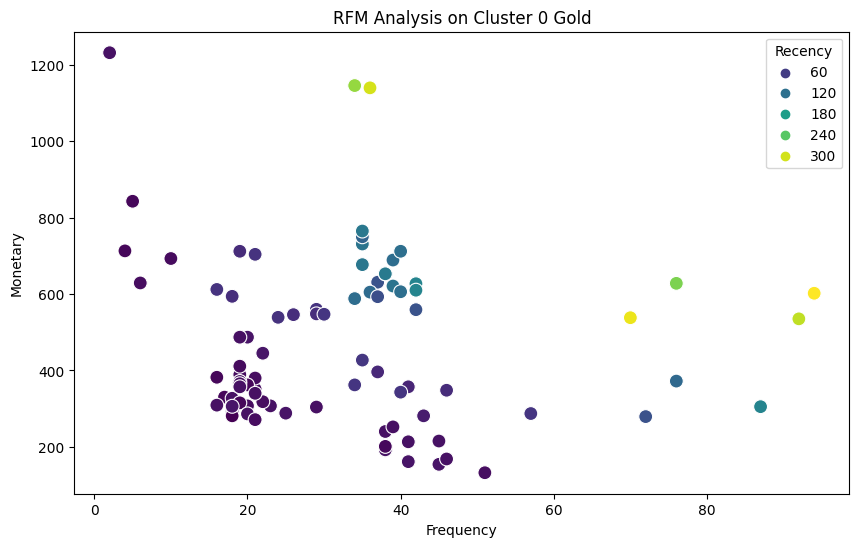

In [162]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=c0_gold, x='Frequency', y='Monetary', hue='Recency', palette='viridis', s=100)


plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 0 Gold')
plt.legend(title='Recency')


plt.show()

In [163]:
c1_gold.describe().T

count          mean          std      min       25%      50%  \
CustomerID  594.0  15689.681818  1555.984422  12822.0  14344.50  15810.5   
Recency     594.0     64.771044    57.712681      0.0     24.00     50.0   
Frequency   594.0     53.043771    30.688031      3.0     33.00     46.5   
Monetary    594.0    833.675084   451.049749    120.0    528.25    712.5   
R-Score     594.0      2.313131     0.923515      1.0      2.00      2.0   
F-Score     594.0      2.112795     0.738535      1.0      2.00      2.0   
M-Score     594.0      2.043771     0.767007      1.0      2.00      2.0   
RFMScore    594.0      6.469697     0.499502      6.0      6.00      6.0   
Cluster_ID  594.0      1.000000     0.000000      1.0      1.00      1.0   

                 75%      max  
CustomerID  16996.50  18265.0  
Recency        85.00    317.0  
Frequency      63.00    192.0  
Monetary     1031.75   2643.0  
R-Score         3.00      4.0  
F-Score         3.00      4.0  
M-Score         3.00      4.0  
RFMScore        7.00      7.0  
Cluster_ID      1.00      1.0

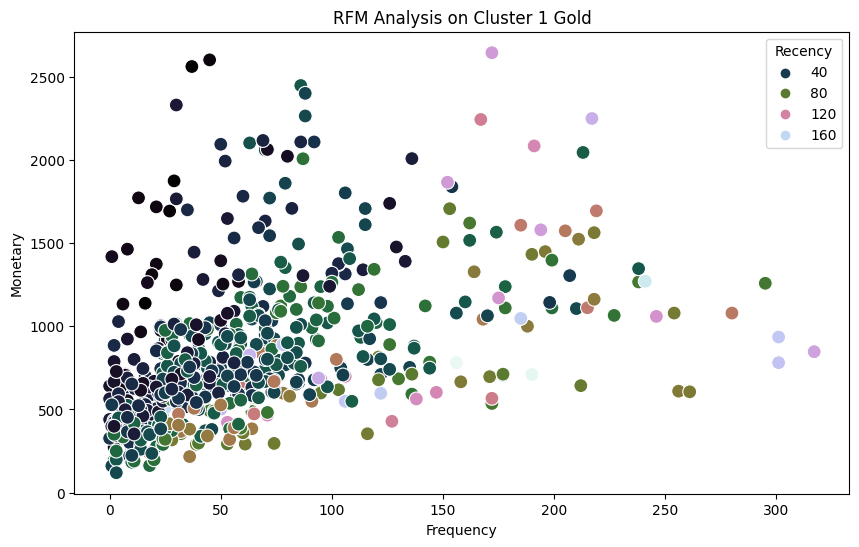

In [164]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=c1_gold, x='Recency', y='Monetary', hue='Frequency', palette='cubehelix', s=100)

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 1 Gold')
plt.legend(title='Recency')


plt.show()

In [165]:
c0_silver.describe().T

count          mean          std      min       25%      50%  \
CustomerID  646.0  15565.099071  1560.527565  12823.0  14300.25  15553.5   
Recency     646.0     92.972136    82.574594      0.0     31.00     64.0   
Frequency   646.0     25.425697    16.534668      1.0     14.00     23.0   
Monetary    646.0    423.640867   271.343647     30.0    250.00    371.5   
R-Score     646.0      2.575851     1.012927      1.0      2.00      3.0   
F-Score     646.0      3.026316     0.760001      1.0      3.00      3.0   
M-Score     646.0      2.979876     0.790190      1.0      2.00      3.0   
RFMScore    646.0      8.582043     0.493605      8.0      8.00      9.0   
Cluster_ID  646.0      0.000000     0.000000      0.0      0.00      0.0   

                 75%      max  
CustomerID  16854.25  18282.0  
Recency       132.00    329.0  
Frequency      33.00     88.0  
Monetary      543.75   2033.0  
R-Score         3.00      4.0  
F-Score         4.00      4.0  
M-Score         4.00      4.0  
RFMScore        9.00      9.0  
Cluster_ID      0.00      0.0

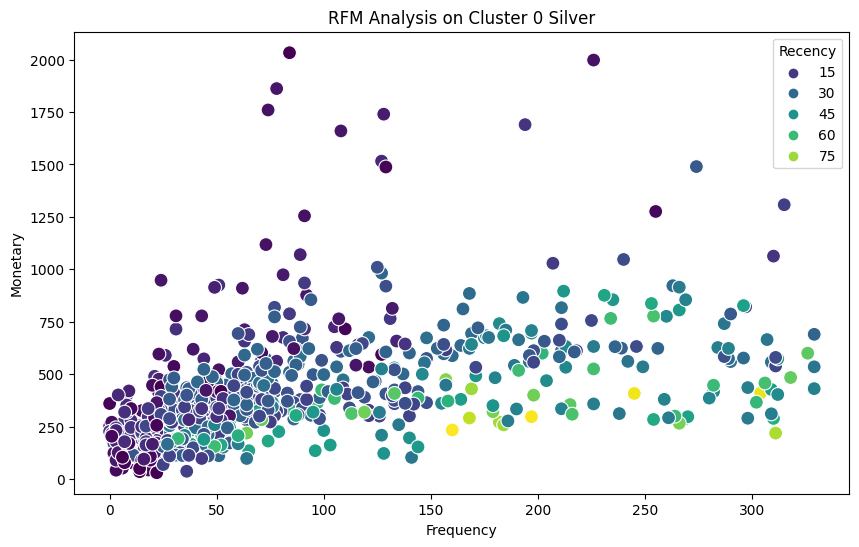

In [166]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=c0_silver, x='Recency', y='Monetary', hue='Frequency', palette='viridis', s=100)


plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 0 Silver')
plt.legend(title='Recency')

plt.show()

In [167]:
c1_silver.describe().T

count          mean          std      min       25%      50%  \
CustomerID   66.0  15235.090909  1438.933994  12924.0  13823.75  15086.5   
Recency      66.0    109.212121    76.897237      0.0     35.75     82.0   
Frequency    66.0     43.863636    23.684390      8.0     28.00     33.0   
Monetary     66.0    776.333333   416.399820    210.0    479.75    832.5   
R-Score      66.0      3.045455     0.918725      1.0      2.00      3.0   
F-Score      66.0      2.530303     0.748736      1.0      2.00      3.0   
M-Score      66.0      2.424242     0.765820      1.0      2.00      2.0   
RFMScore     66.0      8.000000     0.000000      8.0      8.00      8.0   
Cluster_ID   66.0      1.000000     0.000000      1.0      1.00      1.0   

                 75%      max  
CustomerID  16542.75  18205.0  
Recency       176.00    279.0  
Frequency      57.00    132.0  
Monetary      958.50   2207.0  
R-Score         4.00      4.0  
F-Score         3.00      4.0  
M-Score         3.00      4.0  
RFMScore        8.00      8.0  
Cluster_ID      1.00      1.0

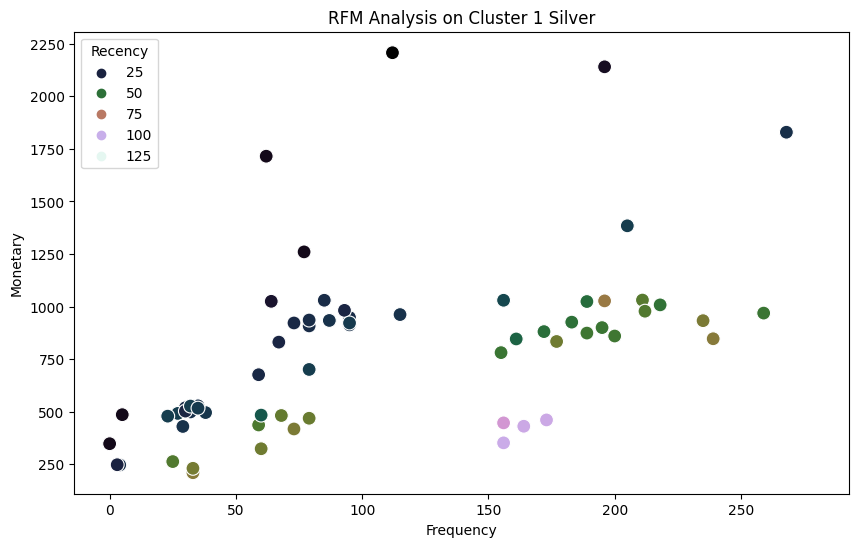

In [168]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=c1_silver, x='Recency', y='Monetary', hue='Frequency', palette='cubehelix', s=100)

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Analysis on Cluster 1 Silver')
plt.legend(title='Recency')

plt.show()

In [169]:
c0_gold[['Recency', 'Frequency', 'Monetary']].mean()

Recency       63.534091
Frequency     32.840909
Monetary     465.750000
dtype: float64

In [170]:
crt = RFM1.copy()

In [171]:
x = crt.iloc[:,1:4]
y=crt.iloc[:,-1]

In [172]:
x.head()

Recency  Frequency  Monetary
4        2         59       942
5      213          6        93
6       70         46       949
7       74          5      1760
8       59         25       397

In [173]:
y.head()

4    1
5    0
6    1
7    0
8    0
Name: Cluster_ID, dtype: int32

In [174]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [175]:
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_test = std.fit_transform(x_test)

In [176]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
prd = lr.predict(x_test)

In [177]:
prd

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,

In [178]:
model_accuracy = accuracy_score(prd,y_test)
model_accuracy

0.9371069182389937

In [179]:
ly = crt.iloc[:,-2]

In [180]:
lx_train,lx_test,ly_train,ly_test = train_test_split(x,ly,test_size=0.2, random_state=42)

In [181]:
lx_train = std.fit_transform(lx_train)
lx_test = std.fit_transform(lx_test)

In [182]:
ran_obj = RandomForestClassifier()
ran_obj.fit(lx_train,ly_train)
ran_obj.score(lx_test,ly_test)

0.8867924528301887

In [183]:
nb_classifier = GaussianNB()
nb_classifier.fit(lx_train, ly_train)
print("Naive Bayes classifier accuracy")
nb_classifier.score(lx_test,ly_test)

Naive Bayes classifier accuracy


0.6981132075471698

In [184]:
dt_obj = DecisionTreeClassifier()
dt_obj.fit(lx_train,ly_train)
print("Decision Tree Classifier accuracy")
dt_obj.score(lx_test,ly_test)

Decision Tree Classifier accuracy


0.8852201257861635

In [185]:
svc_obj = svm.SVC()
svc_obj.fit(lx_train,ly_train)
print("SVC model accuracy ")
svc_obj.score(lx_test,ly_test)

SVC model accuracy 


0.8522012578616353

In [200]:
def get_customer_info(customer_id):
    customer_data = RFM1[RFM1['CustomerID'] == customer_id]
    if not customer_data.empty:
        loyalty_level = customer_data['LoyaltyLevel'].values[0]
        recency = customer_data['Recency'].values[0]
        frequency = customer_data['Frequency'].values[0]
        monetary = customer_data['Monetary'].values[0]
        return loyalty_level, recency, frequency, monetary
    else:
        return None


input_customer_id = int(input("Enter Customer ID: "))
result = get_customer_info(input_customer_id)

if result:
    loyalty_level, recency, frequency, monetary = result
    print(f'Customer ID: {input_customer_id}')
    print(f'Loyalty Level: {loyalty_level}')
    print(f'Recency: {recency}')
    print(f'Frequency: {frequency}')
    print(f'Monetary: {monetary}')
else:
    print(f'Customer ID {input_customer_id} not found.')

Enter Customer ID: 13122
Customer ID: 13122
Loyalty Level: Gold
Recency: 93
Frequency: 55
Monetary: 922


In [187]:
new_data = (80,1,10)

input_array = np.asarray(new_data)

data_reshape = input_array.reshape(1,-1)

std_input = std.transform(data_reshape)

cluster = lr.predict(std_input)     # Logistic Regression based on Kmeans result (Cluster ID)

loyalty = ran_obj.predict(std_input)   # Random Forest Based on RFM Modeling

if (cluster[0]==0):
  print("Customer belong to Cluster 0")
else:
  print("Customer belong to Cluster 1")

print("Loyalty level :", loyalty[0] )

Customer belong to Cluster 0
Loyalty level : Bronze


In [188]:
# Save the trained models using joblib
joblib.dump(std, 'std_model.joblib')
joblib.dump(lr, 'lr_model.joblib')
joblib.dump(ran_obj, 'ran_obj_model.joblib')

In [189]:
# Load the trained models using joblib
std_Job= joblib.load('std_model.joblib')
lr_Job = joblib.load('lr_model.joblib')
ran_obj_Job = joblib.load('ran_obj_model.joblib')

In [190]:
merge = pd.merge(df[['CustomerID', 'Description', 'Quantity']], RFM1[['CustomerID',"Cluster_ID"]], on='CustomerID', how='inner')
merge.rename(columns={'Description': 'Product'}, inplace=True)
merge.head()

CustomerID                          Product  Quantity  Cluster_ID
0       13748  PAPER CHAIN KIT 50'S CHRISTMAS         80           1
1       13748        BISCUIT TIN VINTAGE GREEN         2           1
2       13748     ROUND CAKE TIN VINTAGE GREEN         2           1
3       13748  3 TIER CAKE TIN GREEN AND CREAM         2           1
4       13748         REGENCY CAKESTAND 3 TIER         2           1

In [191]:
recommendations_by_cluster = {}

for cluster_id in range(2):
    cluster_df = merge[merge['Cluster_ID'] == cluster_id]
    product_cluster = cluster_df.groupby("Product")["Quantity"].sum().reset_index()
    sorted_products = product_cluster.sort_values(by="Quantity", ascending=False)
    top_5_products = sorted_products.head(5)
    recommendations_by_cluster[cluster_id] = top_5_products

for cluster_id in range(2):
    cluster_recommendations = recommendations_by_cluster.get(cluster_id)
    print(f"Top 5 recommendations for Cluster {cluster_id}:\n{cluster_recommendations}\n")

Top 5 recommendations for Cluster 0:
                                  Product  Quantity
913   ESSENTIAL BALM 3.5g TIN IN ENVELOPE      5586
417                   BROCADE RING PURSE       4890
182             ASSORTED COLOURS SILK FAN      4124
2567          SMALL CHINESE STYLE SCISSOR      3698
2943   WHITE HANGING HEART T-LIGHT HOLDER      2765

Top 5 recommendations for Cluster 1:
                                 Product  Quantity
3467   WORLD WAR 2 GLIDERS ASSTD DESIGNS     12568
2961         SMALL CHINESE STYLE SCISSOR      9263
200        ASSORTED COLOUR BIRD ORNAMENT      9027
3385  WHITE HANGING HEART T-LIGHT HOLDER      6510
1596             JUMBO BAG RED RETROSPOT      6190

